In [1]:
import pymysql
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
from sklearn.cluster import KMeans
from collections import Counter
import seaborn as sns
import json
from dou_clean import *
pd.set_option('max_columns', 300)
pd.set_option('max_rows',1000)

In [7]:
def process_data():
    connection = pymysql.connect(host = '127.0.0.1', user = 'root', password = 'root123', db = 'douyin')
    data = pd.read_sql_query('select * from base_user_info',connection)
    connection.close()
    data = data.fillna('Missing')
    
    data.region_rate = data.region_rate.apply(parse_region_rate)
    cities = sorted(list(get_all_cities(data)))
    id2city = {i:c for i, c in enumerate(cities)}
    city2id = {c:i for i,c in id2city.items()}
    data['region_vector'] = data.region_rate.apply(make_region_vector,n_cities = len(cities), city2id = city2id)
    
    data.age_rate = data.age_rate.apply(parse_age_rate)
    ages = sorted(list(get_all_ages(data)))
    id2age = {i:a for i, a in enumerate(ages)}
    age2id = {v:k for k,v in id2age.items()}
    data['age_vector'] = data.age_rate.apply(make_age_vector, n_ages = len(ages), age2id = age2id)
    
    
    data['fans_active_daily_counts'] = data.fans_active_day_rate.apply(get_fans_counts, col = 'Count')
    data['fans_active_daily_pcts'] = data.fans_active_day_rate.apply(get_fans_counts, col = 'Percent')
    data = fill_none_wt_zero_lists(data, 'fans_active_daily_counts',24)
    data = fill_none_wt_zero_lists(data, 'fans_active_daily_pcts',24)
    
    data['comment_cloud'] = data.comment_cloud.apply(parse_word_cloud)
    vocab = get_vab(data)
    word2index = {word:i for i, word in enumerate(vocab)}
    index2word = {v:k for k,v in word2index.items()}
    data['word_vector'] = data.comment_cloud.apply(make_word_vector, word2index = word2index, vocab_size = len(vocab))
    
    data['weekly_fans_count_vector'] = data.fans_active_week_rate.apply(make_weekly_vector, col = 'Count')
    data['weekly_fans_percent_vector'] = data.fans_active_week_rate.apply(make_weekly_vector, col = 'Percent')
    
    maps = {'city2id':city2id,
           'id2city': id2city,
           'age2id':age2id,
           'id2age':id2age,
           'word2index':word2index,
           'index2word':index2word}
    
    
    
    return data, maps


def clustering_inertials(data, feature_name = 'age_vector'):
    vectors = np.array([np.array(l) for l in data[feature_name].values])

    inertials = []
    for i in range(2,20):
        kmeans = KMeans(n_clusters = i)
        kmeans.fit(vectors)
        inertials.append(kmeans.inertia_)
    figsize(8,6)
    plt.title('N_clusters')
    plt.plot(inertials, marker = '.', markersize = 20,linewidth = 3)
    plt.grid(linestyle = '--')
    plt.show()
    
    
def kmeans_predict(data, n_clusters, feature_name):
    vectors = np.array([np.array(l) for l in data[feature_name].values])
    labels = KMeans(n_clusters = n_clusters, random_state=42).fit_predict(vectors)
    data[feature_name + '_label'] = labels
    
    counts = data[feature_name + '_label'].value_counts()
    plt.bar(counts.index,counts.values)
    plt.title('Class Count distribution')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.show()
    return data

def evaluate_clustering(data, feature_name, label_name, vector_name_mapping, class_length = None):
    if not vector_name_mapping is None:
        column_names = list(vector_name_mapping.values())  
    else:
        column_names = np.arange(class_length)
        
    df = pd.DataFrame(np.array([np.array(l) for l in data[feature_name].values]),columns = column_names)
    df['label'] = data[label_name]
    df['uid'] = data['uid']
    df['name'] = data['name']
    
    figsize(15,8)
    snake_melt = pd.melt(df.reset_index(), 
                        id_vars=['uid', 'name','label'],
                        value_vars=column_names, 
                        var_name='Attribute', 
                        value_name='Value')

    plt.title('Snake plot of standardized variables')
    sns.lineplot(x="Attribute", y="Value", hue='label', data=snake_melt,legend = 'full')
    plt.show()

In [3]:
data,maps = process_data()

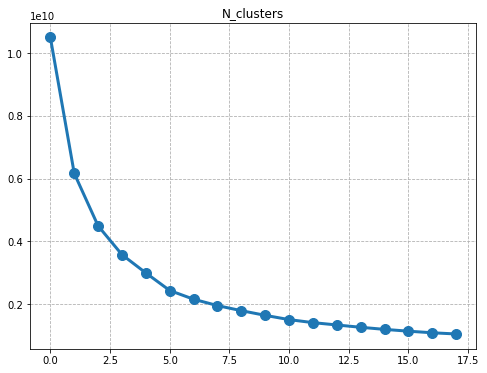

In [4]:
clustering_inertials(data,'age_vector')

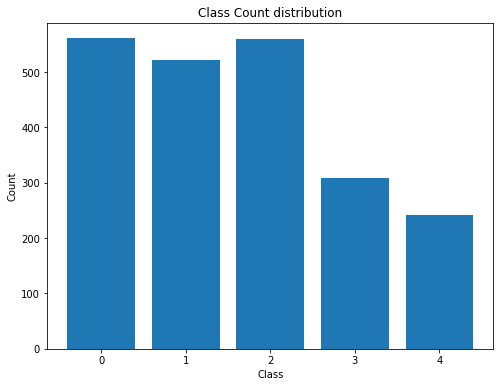

In [5]:
data = kmeans_predict(data,5,'age_vector')

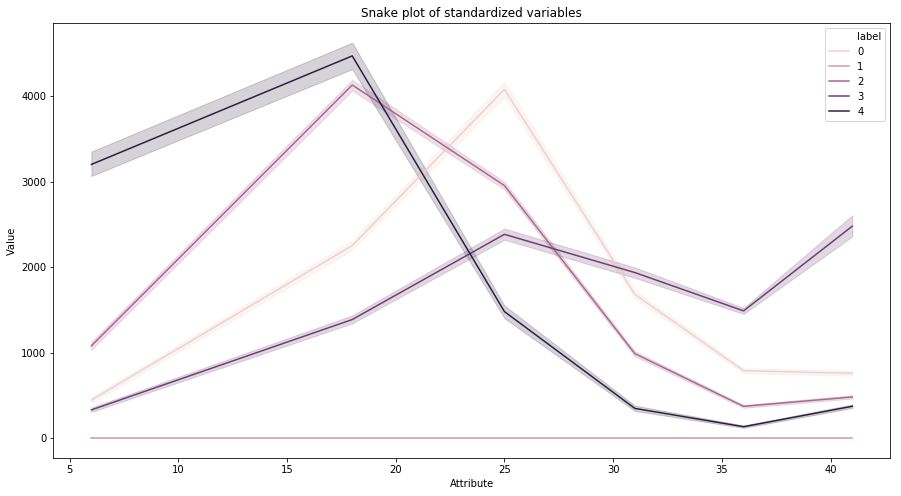

In [8]:
evaluate_clustering(data, 'age_vector', 'age_vector_label',maps['id2age'])

In [9]:
data[data['age_vector_label'] == 3].sort_values(by = 'likes', ascending = False).head()

,id,uid,name,douyin_id,is_shop,sex,region,age,tag,douyin_tag,description,fans,videos,feigua_index,is_blue_vip,cert_persional,cert,likes,avg_comments,avg_shares,comment_cloud,male_fans_rate,female_fans_rate,region_rate,age_rate,fans_active_day_rate,fans_active_week_rate,region_vector,age_vector,fans_active_daily_counts,fans_active_daily_pcts,word_vector,weekly_fans_count_vector,weekly_fans_percent_vector,age_vector_label
406,364845,69389515579,吴老师正能量,wb0521,1,1,上海,39,体育,Missing,支持民族品牌 支持助农扶农\n吴老师严选团队致力把控商品\n全网唯一账号 独家抖音平台签约\...,4778000,107,1114.5,1,正能量人气达人,Missing,57639000,599,793,"{'吴老师': 471, '能量': 192, '支持': 132, '杨梅': 90, '...",64.99,35.01,"{'广东': 0.1192, '江苏': 0.1013, '浙江': 0.0803, '上海...","{6: 322, 18: 1412, 25: 2708, 31: 2395, 36: 170...","[{""Name"": ""00:00"", ""Count"": 8889, ""Origin"": 0,...","[{""Name"": ""周一"", ""Count"": 27579, ""Origin"": 1, ""...","[0.064, 0.0, 0.0, 0.0, 0.0, 0.05, 0.0, 0.0499,...","[322.0, 1412.0, 2708.0, 2395.0, 1705.0, 1459.0]","[8889, 4643, 2320, 1569, 1375, 2125, 3961, 558...","[0.05531459436586413, 0.02889252577800733, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[27579.0, 13657.0, 11795.0, 20671.0, 27790.0, ...","[0.17161898953944954, 0.08498497190399443, 0.0...",3
717,6179147,98674185726,BTV养生堂,950849041,1,0,北京,11,健康,医生,为爱你的人珍惜身体❤️,14967000,1528,898.2,1,Missing,北京卫视《养生堂》节目官方抖音账号,51696000,237,2746,"{'感谢': 222, '老师': 191, '医生': 162, '谢谢': 156, '...",34.10,65.90,"{'广东': 0.0855, '江苏': 0.0784, '河南': 0.0762, '山东...","{6: 285, 18: 1859, 25: 2884, 31: 1754, 36: 118...",{},{},"[0.0, 0.0, 0.0, 0.06860000000000001, 0.0, 0.04...","[285.0, 1859.0, 2884.0, 1754.0, 1188.0, 2031.0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",3
1719,7368183,72201453740,湖北之声,hbzs1046,1,0,Missing,26,体育,Missing,正能量、大视野、暖民生,1660000,3026,732.0,1,Missing,湖北广播电视台新闻广播部官方账号,44573000,148,230,"{'武汉': 928, '感谢': 596, '湖北': 559, '辛苦': 431, '...",54.59,45.41,"{'湖北': 0.2495, '广东': 0.10210000000000001, '江苏'...","{6: 390, 18: 1945, 25: 2726, 31: 1989, 36: 110...","[{""Name"": ""00:00"", ""Count"": 185, ""Origin"": 0, ...","[{""Name"": ""周一"", ""Count"": 750, ""Origin"": 1, ""Pe...","[0.0, 0.0, 0.0, 0.030299999999999997, 0.0, 0.0...","[390.0, 1945.0, 2726.0, 1989.0, 1107.0, 1843.0]","[185, 106, 74, 94, 125, 331, 932, 1878, 1798, ...","[0.01154446177847114, 0.006614664586583463, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[750.0, 350.0, 369.0, 1710.0, 1341.0, 10635.0,...","[0.046801872074883, 0.0218408736349454, 0.0230...",3
1224,6444186,71197094750,大脸妹脸大,86449030,0,0,商丘市,29,体育,功夫,感谢抖音平台\n有事➕私人微1657324000备注来意！,4033000,242,1042.6,1,Missing,Missing,43775000,3698,707,"{'美女': 956, '功夫': 814, '厉害': 725, '喜欢': 392, '...",73.67,26.33,"{'河南': 0.138, '江苏': 0.1166, '安徽': 0.0974, '山东'...","{6: 202, 18: 890, 25: 1504, 31: 1543, 36: 1679...","[{""Name"": ""00:00"", ""Count"": 5311, ""Origin"": 0,...","[{""Name"": ""周一"", ""Count"": 23413, ""Origin"": 1, ""...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0974, 0....","[202.0, 890.0, 1504.0, 1543.0, 1679.0, 4182.0]","[5311, 2601, 1524, 998, 1102, 2094, 3831, 4305...","[0.022080772972568455, 0.010813799755535784, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[23413.0, 22958.0, 33242.0, 28115.0, 71220.0, ...","[0.0973408280185926, 0.09544914063344503, 0.13...",3
203,2303141,75947711733,JJYOGA瑜伽,JJYOGA,1,1,北京,29,体育,瑜伽,十三年专业瑜伽教学；\n轮瑜伽体系创始人；\nJJYOGA品牌创始；\n国际瑜伽教培协会授权...,8320000,249,1059.1,1,优质健身领域创作者,Missing,39018000,2629,8099,"{'老师': 1044, '小腿': 276, '动作': 266, '肌肉': 186, ...",21.91,78.09,"{'广东': 0.10869999999999999, '江苏': 0.0713, '山东'...","{6: 603, 18: 2441, 25: 2782, 31: 1540, 36: 966...","[{""Name"": ""00:00"", ""Count"": 4403, ""Origin"": 0,...","[{""Name"": ""周一"", ""Count"": 47030, ""Origin"": 1, ""...","[0.0, 0.0, 0.0, 0.0466, 0.0, 0.0541, 0.0, 0.03...","[603.0, 2441.0, 2782.0,

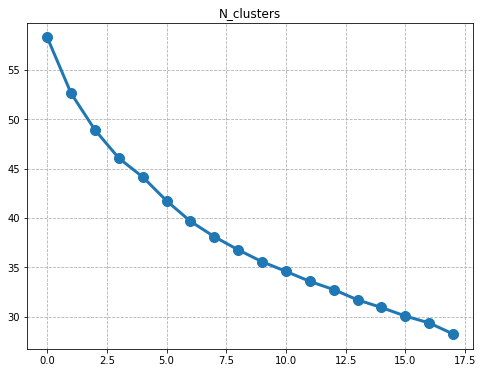

In [18]:
clustering_inertials(data,'fans_active_daily_pcts')

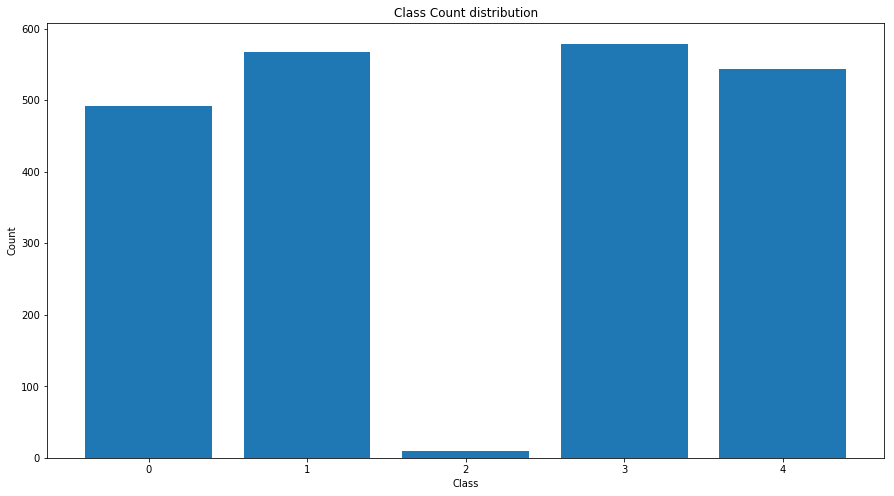

In [25]:
data = kmeans_predict(data,5,'fans_active_daily_pcts')

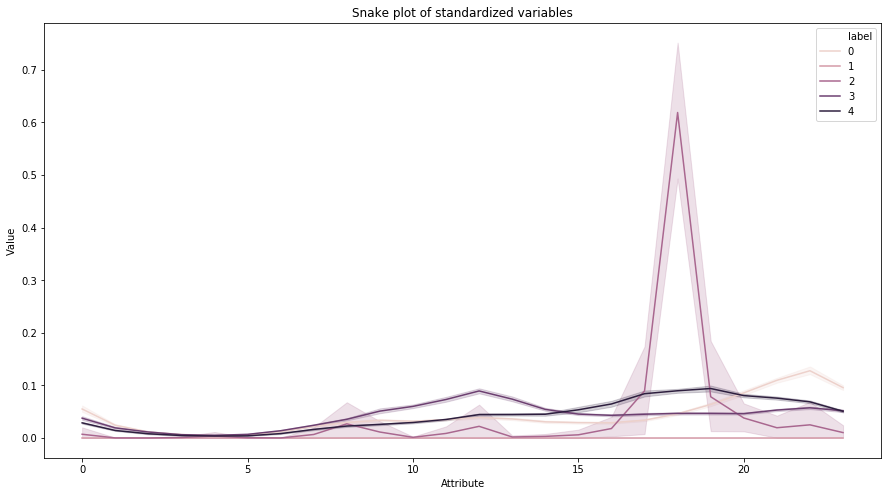

In [26]:
evaluate_clustering(data, 'fans_active_daily_pcts', 'fans_active_daily_pcts_label',vector_name_mapping=None, class_length=24)

In [35]:
data[data['fans_active_daily_pcts_label'] == 2].sort_values(by = 'likes', ascending = False)

,id,uid,name,douyin_id,is_shop,sex,region,age,tag,douyin_tag,description,fans,videos,feigua_index,is_blue_vip,cert_persional,cert,likes,avg_comments,avg_shares,comment_cloud,male_fans_rate,female_fans_rate,region_rate,age_rate,fans_active_day_rate,fans_active_week_rate,region_vector,age_vector,fans_active_daily_counts,fans_active_daily_pcts,word_vector,weekly_fans_count_vector,weekly_fans_percent_vector,age_vector_label,fans_active_daily_counts_label,fans_active_daily_pcts_label
1010,6309266,103665195571,运动功能解析师,1552150725,0,1,鞍山,0,体育,Missing,运动功能性详解\n让每块肌肉找到属于自己的优势\nV♥：jdldy005 \n试看最新课程,610000,8,957.5,1,Missing,Missing,1621000,3,23,"{'腹肌': 2, '动作': 2, '西冷': 1, '收藏': 1, '停止': 1, ...",93.46,6.54,"{'广东': 0.13449999999999998, '山东': 0.0733999999...","{6: 1713, 18: 4995, 25: 2096, 31: 577, 36: 207...","[{""Name"": ""00:00"", ""Count"": 7, ""Origin"": 0, ""P...","[{""Name"": ""周一"", ""Count"": 9, ""Origin"": 1, ""Perc...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0533, 0.0, 0.0409,...","[1713.0, 4995.0, 2096.0, 577.0, 207.0, 410.0]","[7, 3, 1, 0, 0, 0, 2, 1, 1, 5, 6, 20, 22, 18, ...","[0.0056179775280898875, 0.002407704654895666, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[9.0, 19.0, 10.0, 13.0, 17.0, 1126.0, 52.0]","[0.0072231139646869984, 0.015248796147672551, ...",2,1,2
1083,6348156,108057548824,辣妈健身团,1851227714,1,0,运城,27,体育,Missing,坚持不懈，直到成功！,496000,36,740.5,1,Missing,Missing,1288000,0,0,None,38.68,61.32,"{'广东': 0.0901, '山东': 0.0797, '江苏': 0.0758, '河南...","{6: 505, 18: 2094, 25: 3128, 31: 2094, 36: 134...","[{""Name"": ""00:00"", ""Count"": 0, ""Origin"": 0, ""P...","[{""Name"": ""周一"", ""Count"": 1, ""Origin"": 1, ""Perc...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0629, 0.0, 0.0415,...","[505.0, 2094.0, 3128.0, 2094.0, 1342.0, 837.0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0,1,2
52,1273599,64634980203,儒雅的子笺,85326292,0,1,成都市,0,健康,Missing,Missing,598000,0,559.8,1,Missing,Missing,1258000,53,2,"{'子凛': 15, '子笺': 14, '方糖': 10, '小姐姐': 6, '直男':...",29.64,70.36,"{'广东': 0.1069, '四川': 0.0848, '浙江': 0.062800000...","{6: 5985, 18: 3180, 25: 536, 31: 97, 36: 21, 4...","[{""Name"": ""00:00"", ""Count"": 0, ""Origin"": 0, ""P...","[{""Name"": ""周一"", ""Count"": 0, ""Origin"": 1, ""Perc...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0848, 0.0, 0.04759...","[5985.0, 3180.0, 536.0, 97.0, 21.0, 181.0]","[0, 0, 0, 1, 0, 1, 0, 0, 1, 2, 1, 1, 1, 0, 0, ...","[0, 0, 0, 0.005, 0, 0.005, 0, 0, 0.005, 0.01, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 185.0, 15.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.925, 0.075]",4,1,2
176,21945,67556614651,头号玩家,66199613,0,2,鄂州,27,体育,Missing,😌😌喜欢视觉表现的一切东西。,98000,32,530.1,1,Missing,Missing,1199000,17,9,"{'武汉': 13, '去过': 6, '路过': 5, '大道': 3, '地方': 3,...",30.57,69.43,"{'湖北': 0.6093999999999999, '广东': 0.0729, '湖南':...","{6: 502, 18: 3242, 25: 5160, 31: 502, 36: 91, ...","[{""Name"": ""00:00"", ""Count"": 1, ""Origin"": 0, ""P...","[{""Name"": ""周一"", ""Count"": 0, ""Origin"": 1, ""Perc...","[0.0208, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01560...","[502.0, 3242.0, 5160.0, 502.0, 91.0, 502.0]","[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0.0625, 0, 0, 0, 0, 0, 0, 0, 0.0625, 0, 0, 0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 14.0, 2.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.875, 0.125, 0.0, 0.0]",0,1,2
164,2144907,96753357605,衣来神手,781499597,1,0,重庆,23,体育,Missing,只买对的 不买贵的\nVv💕：rufeng122333,426000,79,715.0,1,Missing,Missing,1136000,2,0,None,27.42,72.58,"{'广东': 0.1009, '江苏': 0.0875, '四川': 0.0816, '浙江...","{6: 2032, 18: 7374, 25: 411, 31: 46, 41: 137}","[{""Name"": ""00:00"", ""Count"": 0, ""Origin"": 0, ""P...","[{""Name"": ""周一"", ""Count"": 0, ""Origin"": 1, ""Perc...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0816, 0.0, 0.0326,...","[2032.0, 7374.0, 411.0, 46.0, 0.0, 137.0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 